# Plotting in HSSM

This tutorial demonstrates the plotting functionalities in HSSM.

While the `ArviZ` package provides many plotting utilities, HSSM aims complement the `ArviZ` package with additional types of plots specific for hierarchical sequential sampling models. In addition, HSSM also provides some plotting API directly from the `HSSM` model object with some additional tweaks for convenience.

Most of the plotting and summary functionalities can be found in `hssm.plotting` module, and additional convenience functions are exposed through the top-level `HSSM` model as well.

In [1]:
# If running this on Colab, please uncomment the next line and
# !pip install hssm

In [2]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import hssm
import hssm.plotting

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Model setup

In [3]:
cav_data_test = pd.read_csv("src/cavanagh_theta_test.csv")
cav_data_traces = az.from_netcdf("src/cavanagh_idata.nc")

In [4]:
# For demonstration purposes,
# `cav_data_test` is a subset of the `cavanagh_theta_nn` dataset
# with 5 subjects and 100 observation each

cav_data_test

,participant_id,stim,rt,response,theta,dbs,conf
0,0,WL,0.928,-1.0,-0.521933,0,LC
1,0,WL,0.661,1.0,-0.219645,1,LC
2,0,WW,2.350,-1.0,-0.168728,1,HC
3,0,LL,1.250,-1.0,-0.104636,1,HC
4,0,LL,1.170,-1.0,1.122720,1,HC
...,...,...,...,...,...,...,...
495,4,WL,0.606,-1.0,-0.635942,0,LC
496,4,WL,0.745,-1.0,-0.166833,0,LC
497,4,WW,1.320,1.0,-0.283396,1,HC
498,4,LL,1.640,1.0,0.462584,1,HC


In [5]:
# Model parameter specification

cav_model = hssm.HSSM(
    model="ddm",
    data=cav_data_test,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Normal", "mu": 0.0, "sigma": 1.0},
                "theta": {"name": "Normal", "mu": 0.0, "sigma": 1.0},
            },
            "formula": "v ~  theta + (1|participant_id)",
            "link": "identity",
        },
    ],
)

# Perform sampling
# cav_model.sample()

For demonstration purposes, we inject into the model an existing trace with posterior predictive sampling already performed. A `posterior_predictive` attribute is added to the `traces` object. A `rt,response_mean` variable is also added to the `posterior` attribute during predictive sampling.

In [6]:
# In practice, you would obtain this object by sampling from the model.

cav_model._inference_obj = cav_data_traces
cav_model.traces

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

## Convenience functions from the top-level `hssm.HSSM` model object

The `ArviZ` package provides `az.summary()` and `az.plot_trace()` functions that are very frequently used. We have added these functions through the top-level `hssm.HSSM` model object. The goal is to provide convenience to HSSM users. In addition, these functions provide some nice defaults. For example, in some cases, when some parameters are the targets of regressions, `ArviZ` will also plot the computed values for each regressor on each observation, which is highly inefficient. When convenience functions are used, these computed values will be excluded by default.

### 1. `model.summary()`

The [`model.summary()`][hssm.HSSM.summary] convenience funciton automatically filters out undesirable outputs.

In [7]:
cav_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,0.425,0.268,-0.086,0.936,0.017,0.012,262.0,359.0,1.00
v_theta,0.062,0.048,-0.027,0.150,0.002,0.001,620.0,471.0,1.01
a,1.044,0.024,0.995,1.085,0.001,0.001,831.0,737.0,1.00
z,0.504,0.020,0.467,0.538,0.001,0.000,766.0,643.0,1.00
t,0.337,0.013,0.312,0.363,0.001,0.000,646.0,639.0,1.01
v_1|participant_id_sigma,0.621,0.281,0.237,1.200,0.022,0.016,183.0,221.0,1.01
v_1|participant_id[0],-0.286,0.272,-0.773,0.255,0.017,0.012,266.0,250.0,1.00
v_1|participant_id[1],0.293,0.281,-0.197,0.858,0.017,0.013,280.0,358.0,1.00
v_1|participant_id[2],-0.040,0.279,-0.539,0.501,0.017,0.012,275.0,342.0,1.00
v_1|participant_id[3],-0.382,0.274,-0.895,0.161,0.016,0.012,282.0,326.0,1.00


Compare this with the output of `ArviZ` `az.summary()`:

In [8]:
# Because of posterior predictive sampling, an `rt,response_mean` field was added to
# the traces object by default. ArviZ include these values by default.

# This is equivalent to calling
# cav_model.summary(include_computed_values=True)

az.summary(cav_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,0.425,0.268,-0.086,0.936,0.017,0.012,262.0,359.0,1.00
v_theta,0.062,0.048,-0.027,0.150,0.002,0.001,620.0,471.0,1.01
a,1.044,0.024,0.995,1.085,0.001,0.001,831.0,737.0,1.00
z,0.504,0.020,0.467,0.538,0.001,0.000,766.0,643.0,1.00
t,0.337,0.013,0.312,0.363,0.001,0.000,646.0,639.0,1.01
...,...,...,...,...,...,...,...,...,...
"rt,response_mean[495]",1.054,0.172,0.754,1.394,0.006,0.004,747.0,742.0,1.00
"rt,response_mean[496]",1.083,0.169,0.740,1.369,0.006,0.004,790.0,735.0,1.00
"rt,response_mean[497]",1.076,0.170,0.727,1.363,0.006,0.004,780.0,760.0,1.00
"rt,response_mean[498]",1.122,0.170,0.805,1.432,0.006,0.004,861.0,714.0,1.00


### 2. `model.plot_trace()`

Likewise, [`model.plot_trace()`][hssm.HSSM.plot_trace] is also equivalent to calling `az.plot_trace()` on the model with computed values removed and also calling `plt.tight_layout()`:

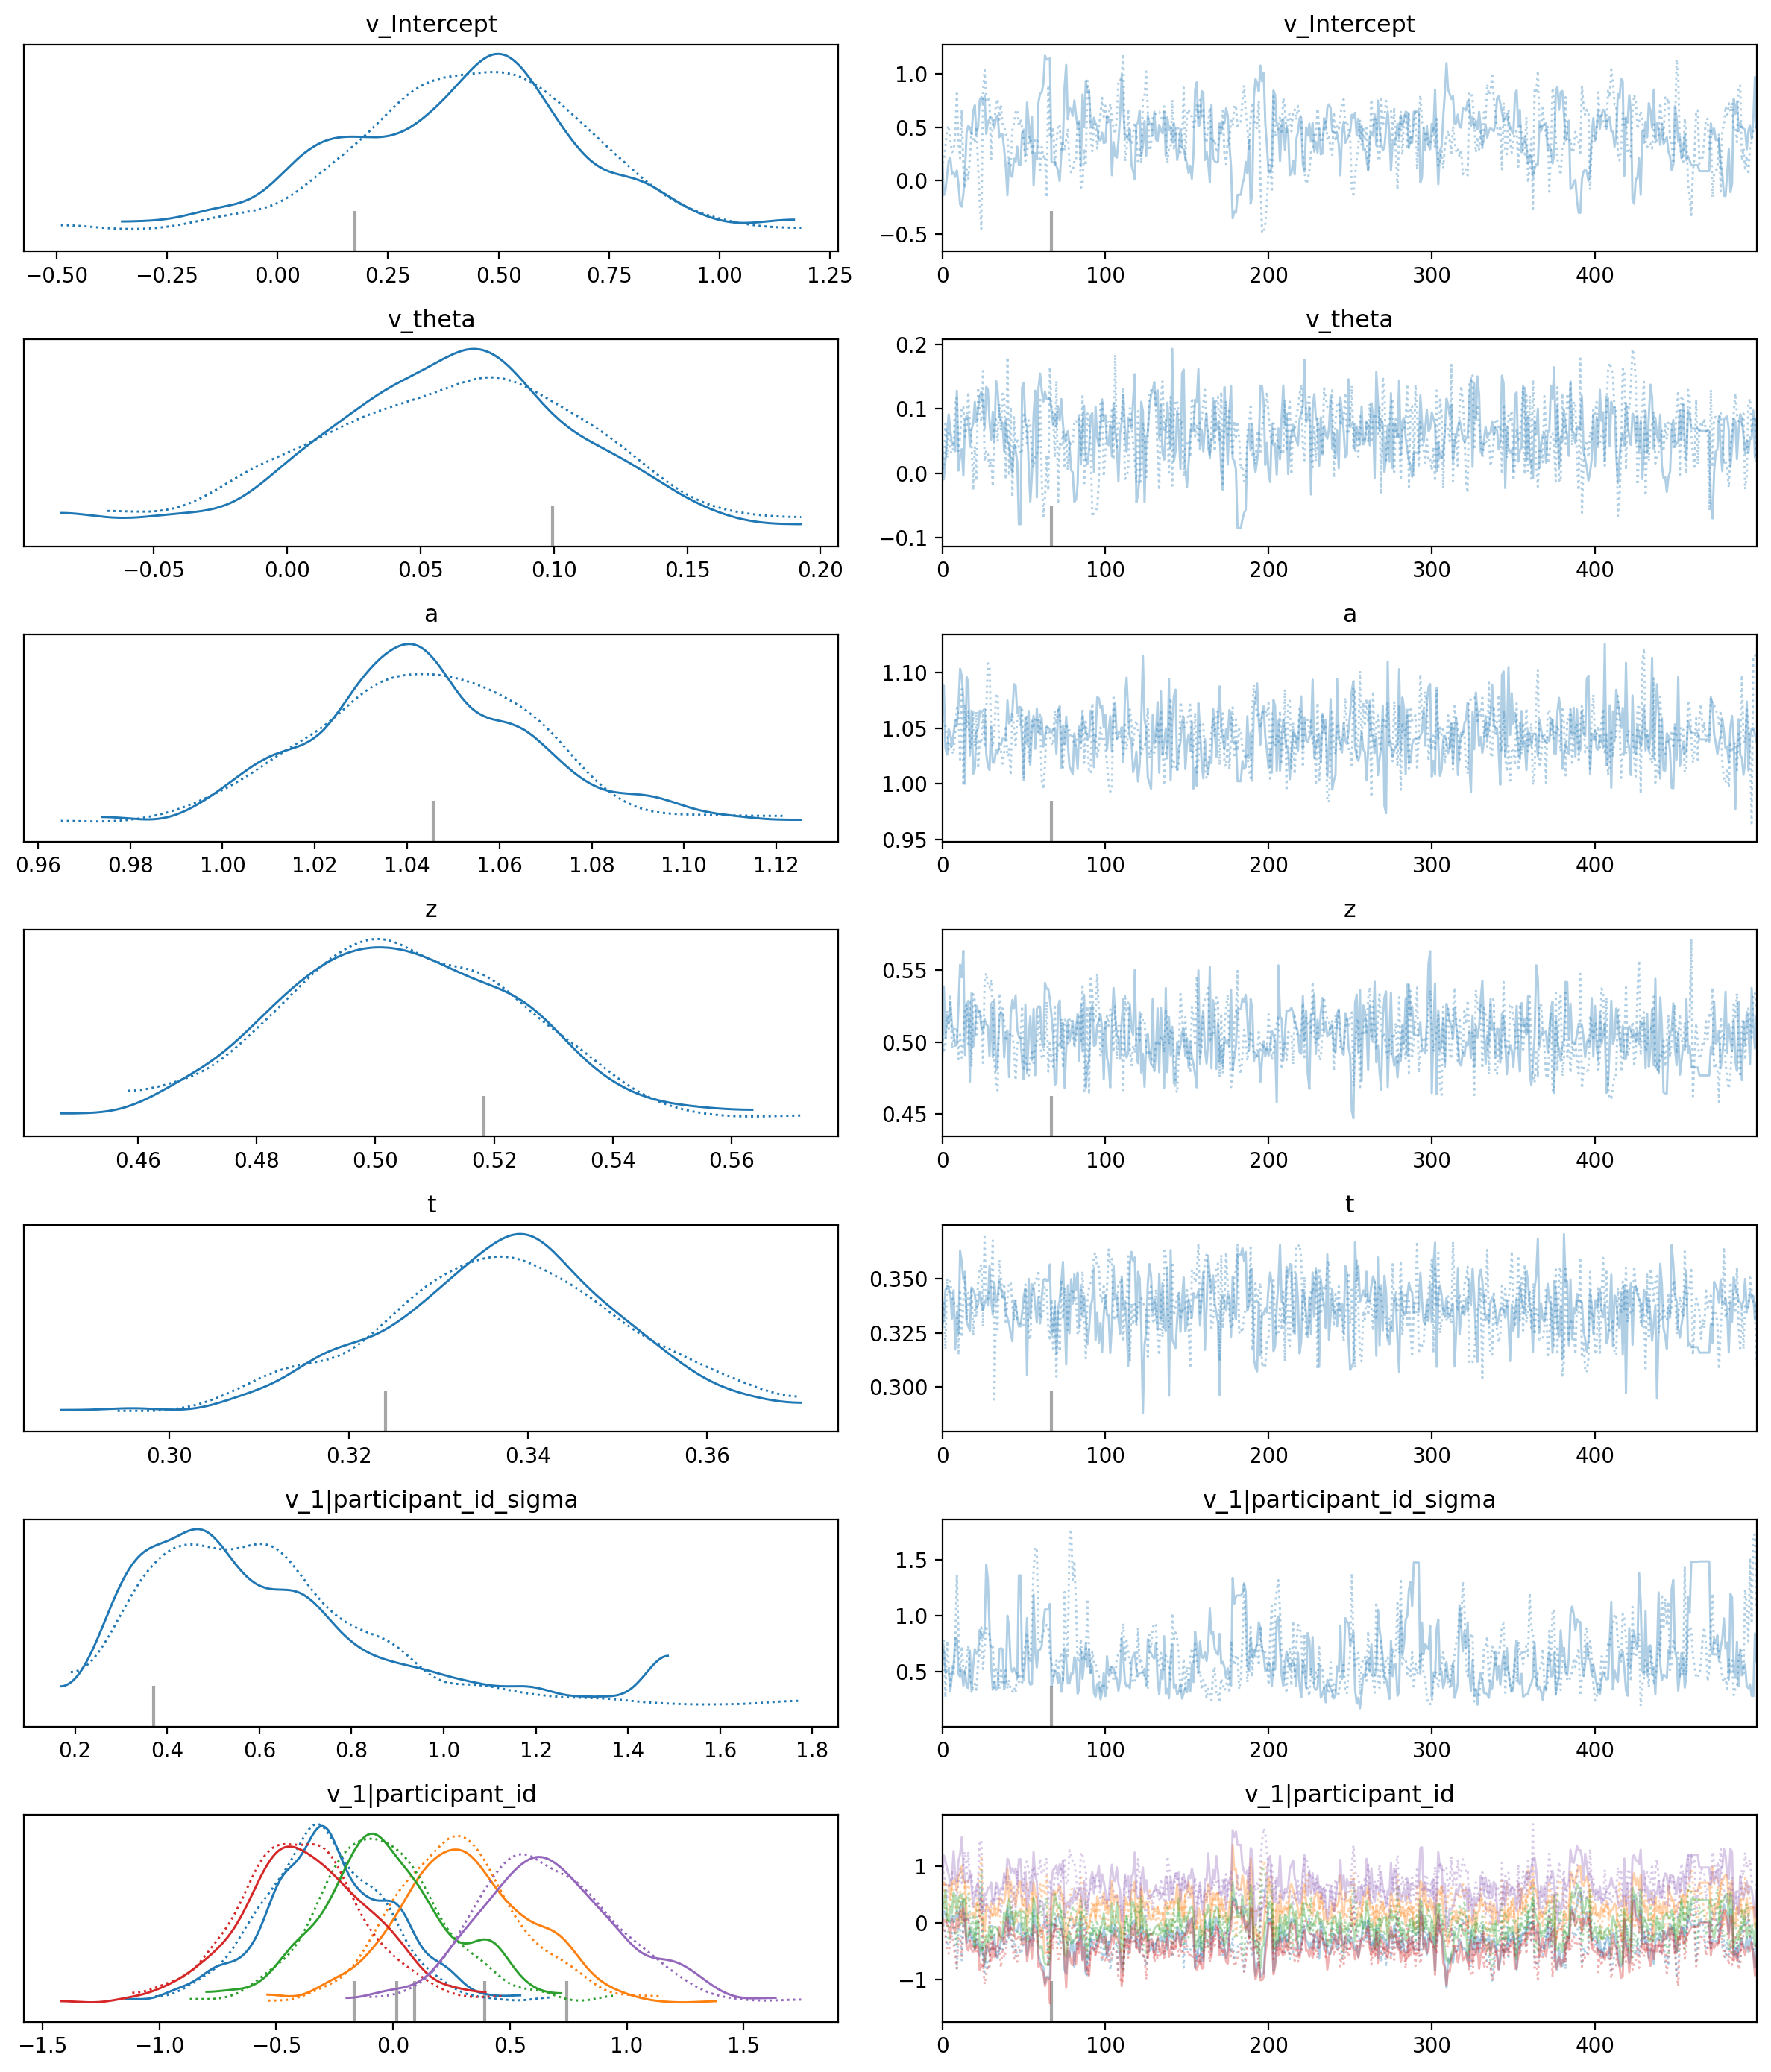

In [9]:
cav_model.plot_trace()

## HSSM-specific plots

HSSM also offers various types of plots specific to hierarchical sequential sampling models.

### 1. Posterior predictive plots

Posterior predictive plots [`hssm.plot_posterior_predictive()`][hssm.plotting.plot_posterior_predictive] plots the distribution of posterior predictive samples against the observed data.

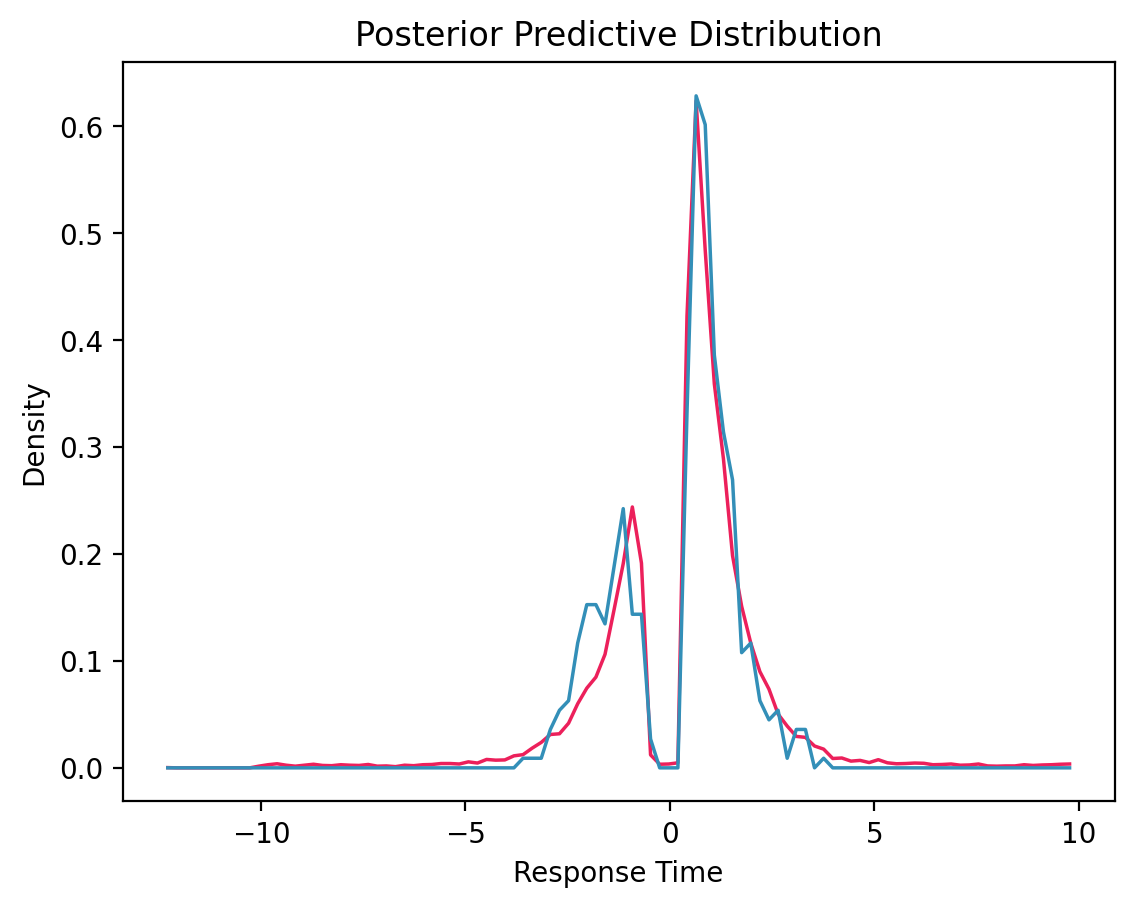

In [10]:
# You can also call
# cav_model.plot_posterior_predictive()

hssm.plotting.plot_posterior_predictive(cav_model);

This API is designed to be a light wrapper around Seaborn's `sns.histplot()` API. It accepts most arguments that `sns.histplot()` accepts. It also returns an `ax` object in matplotlib, so you can manipulate it further.

Text(0.5, 1.0, 'Posterior Predictive Plot')

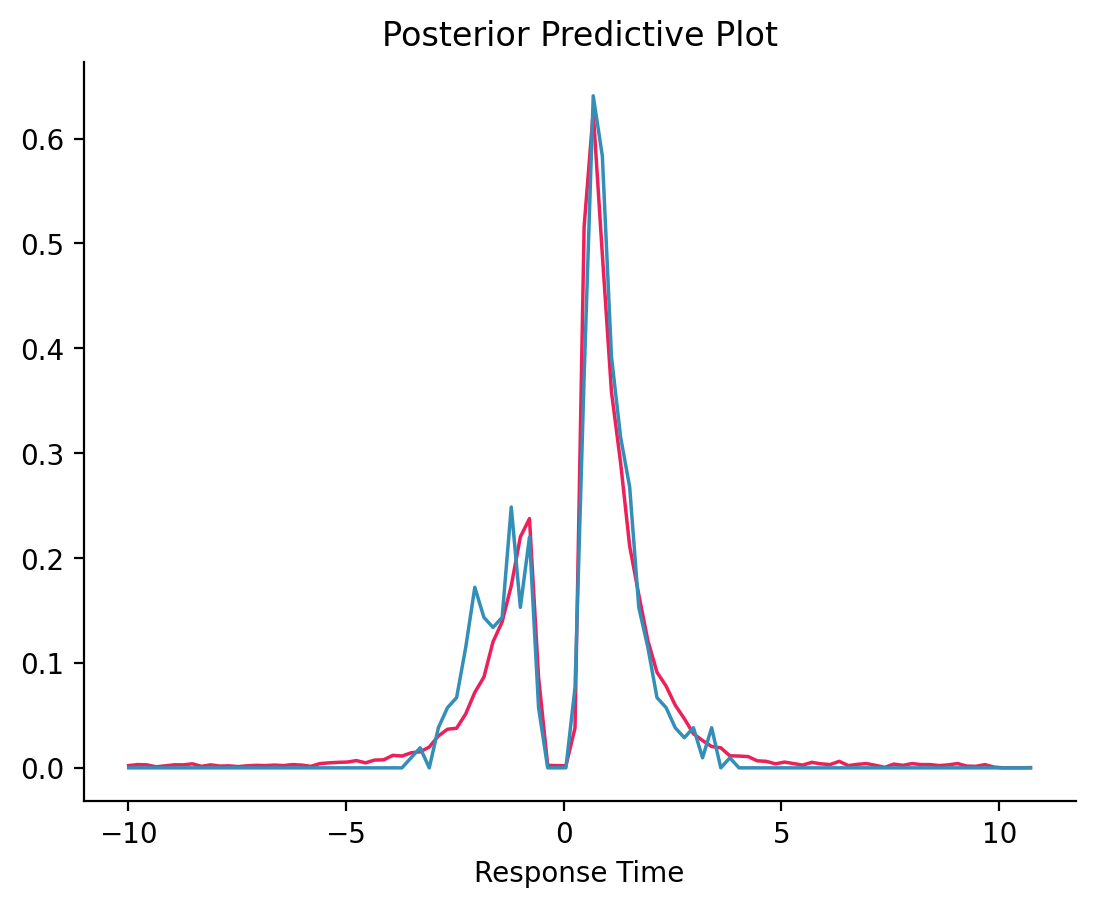

In [11]:
ax = hssm.plotting.plot_posterior_predictive(cav_model)
sns.despine()
ax.set_ylabel("")
plt.title("Posterior Predictive Plot")

You can also plot subsets of data in subplots:

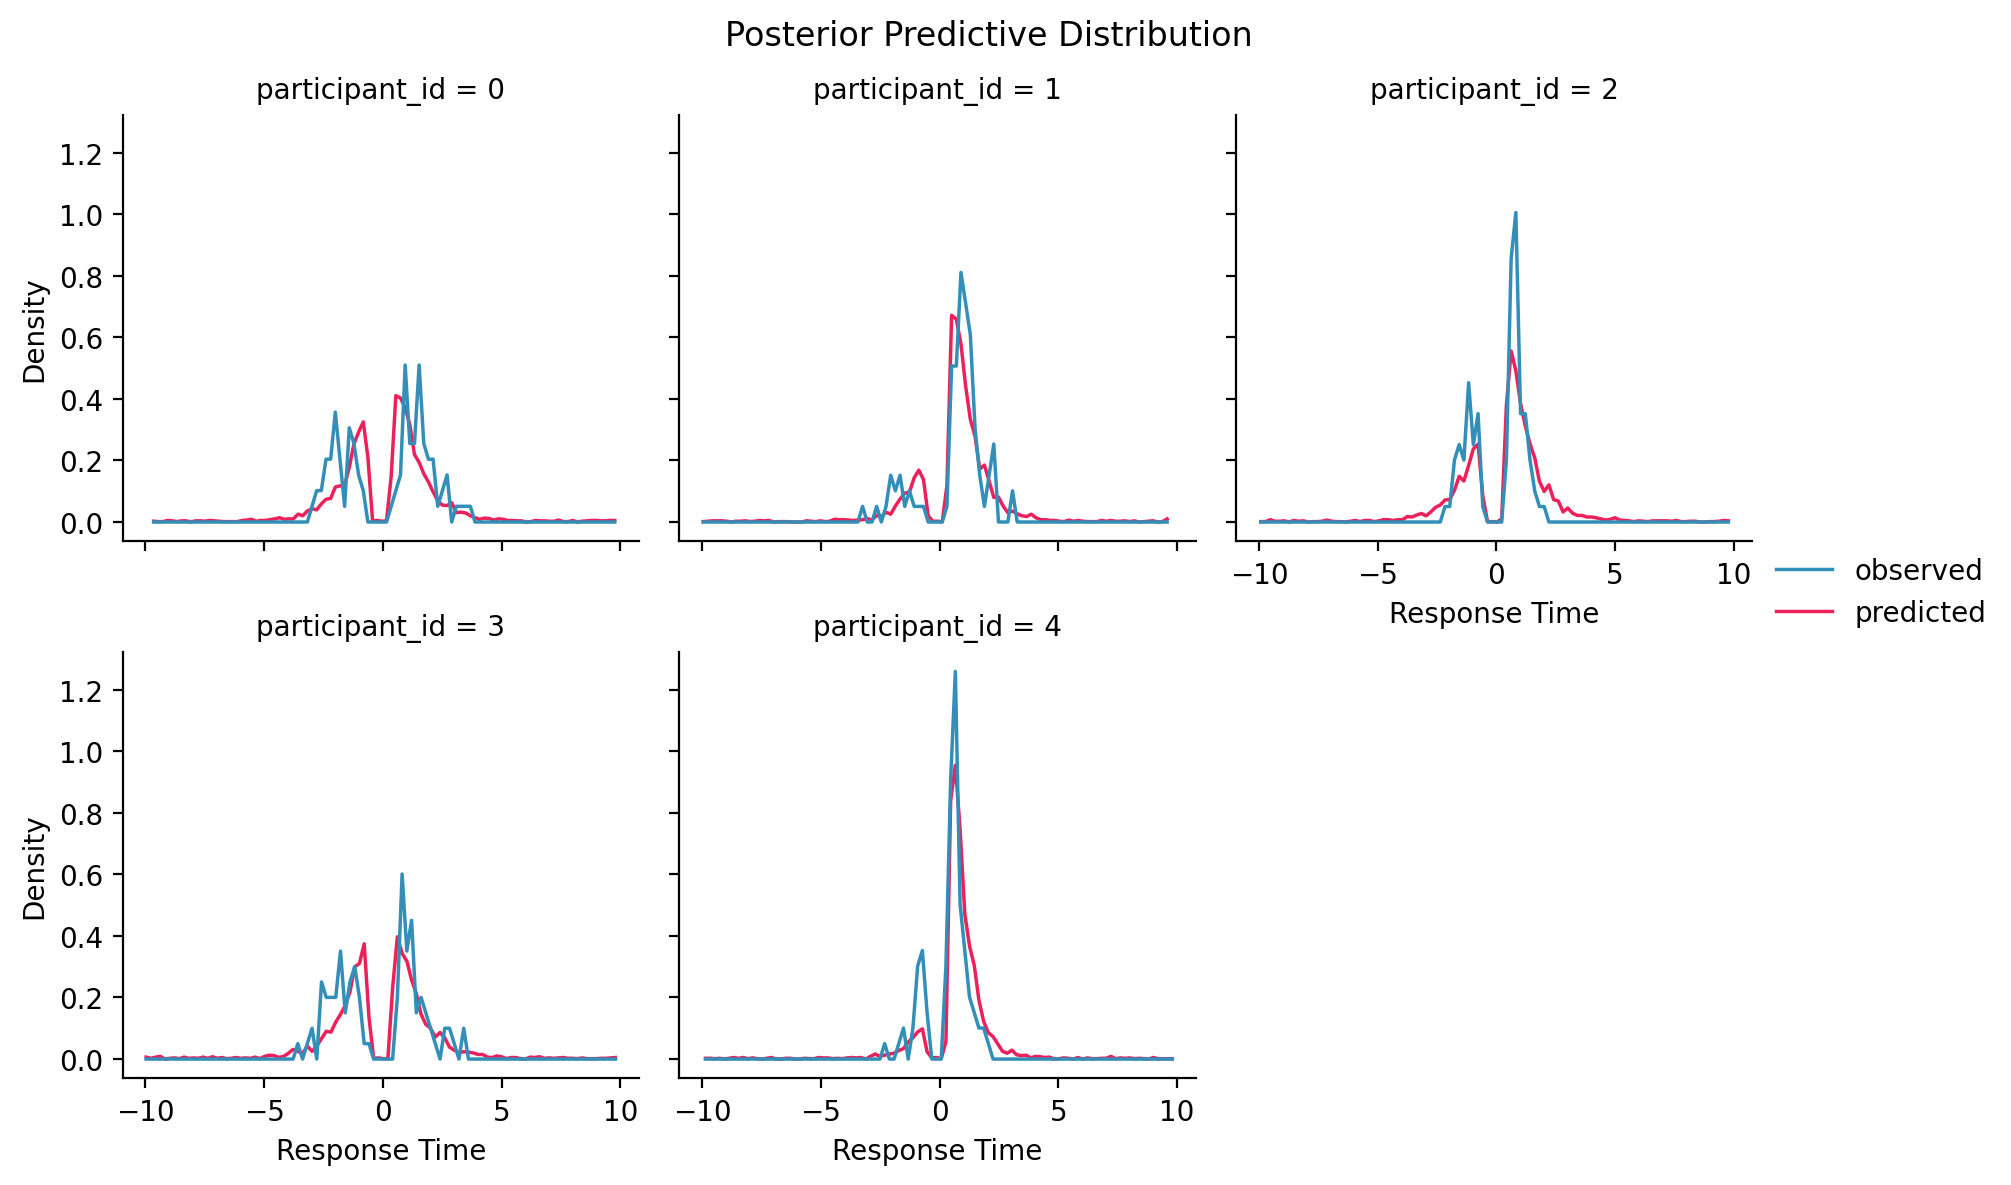

In [12]:
hssm.plotting.plot_posterior_predictive(
    cav_model, col="participant_id", col_wrap=3  # limits to 3 columns per row
)

2-dimensional grids are also possible:

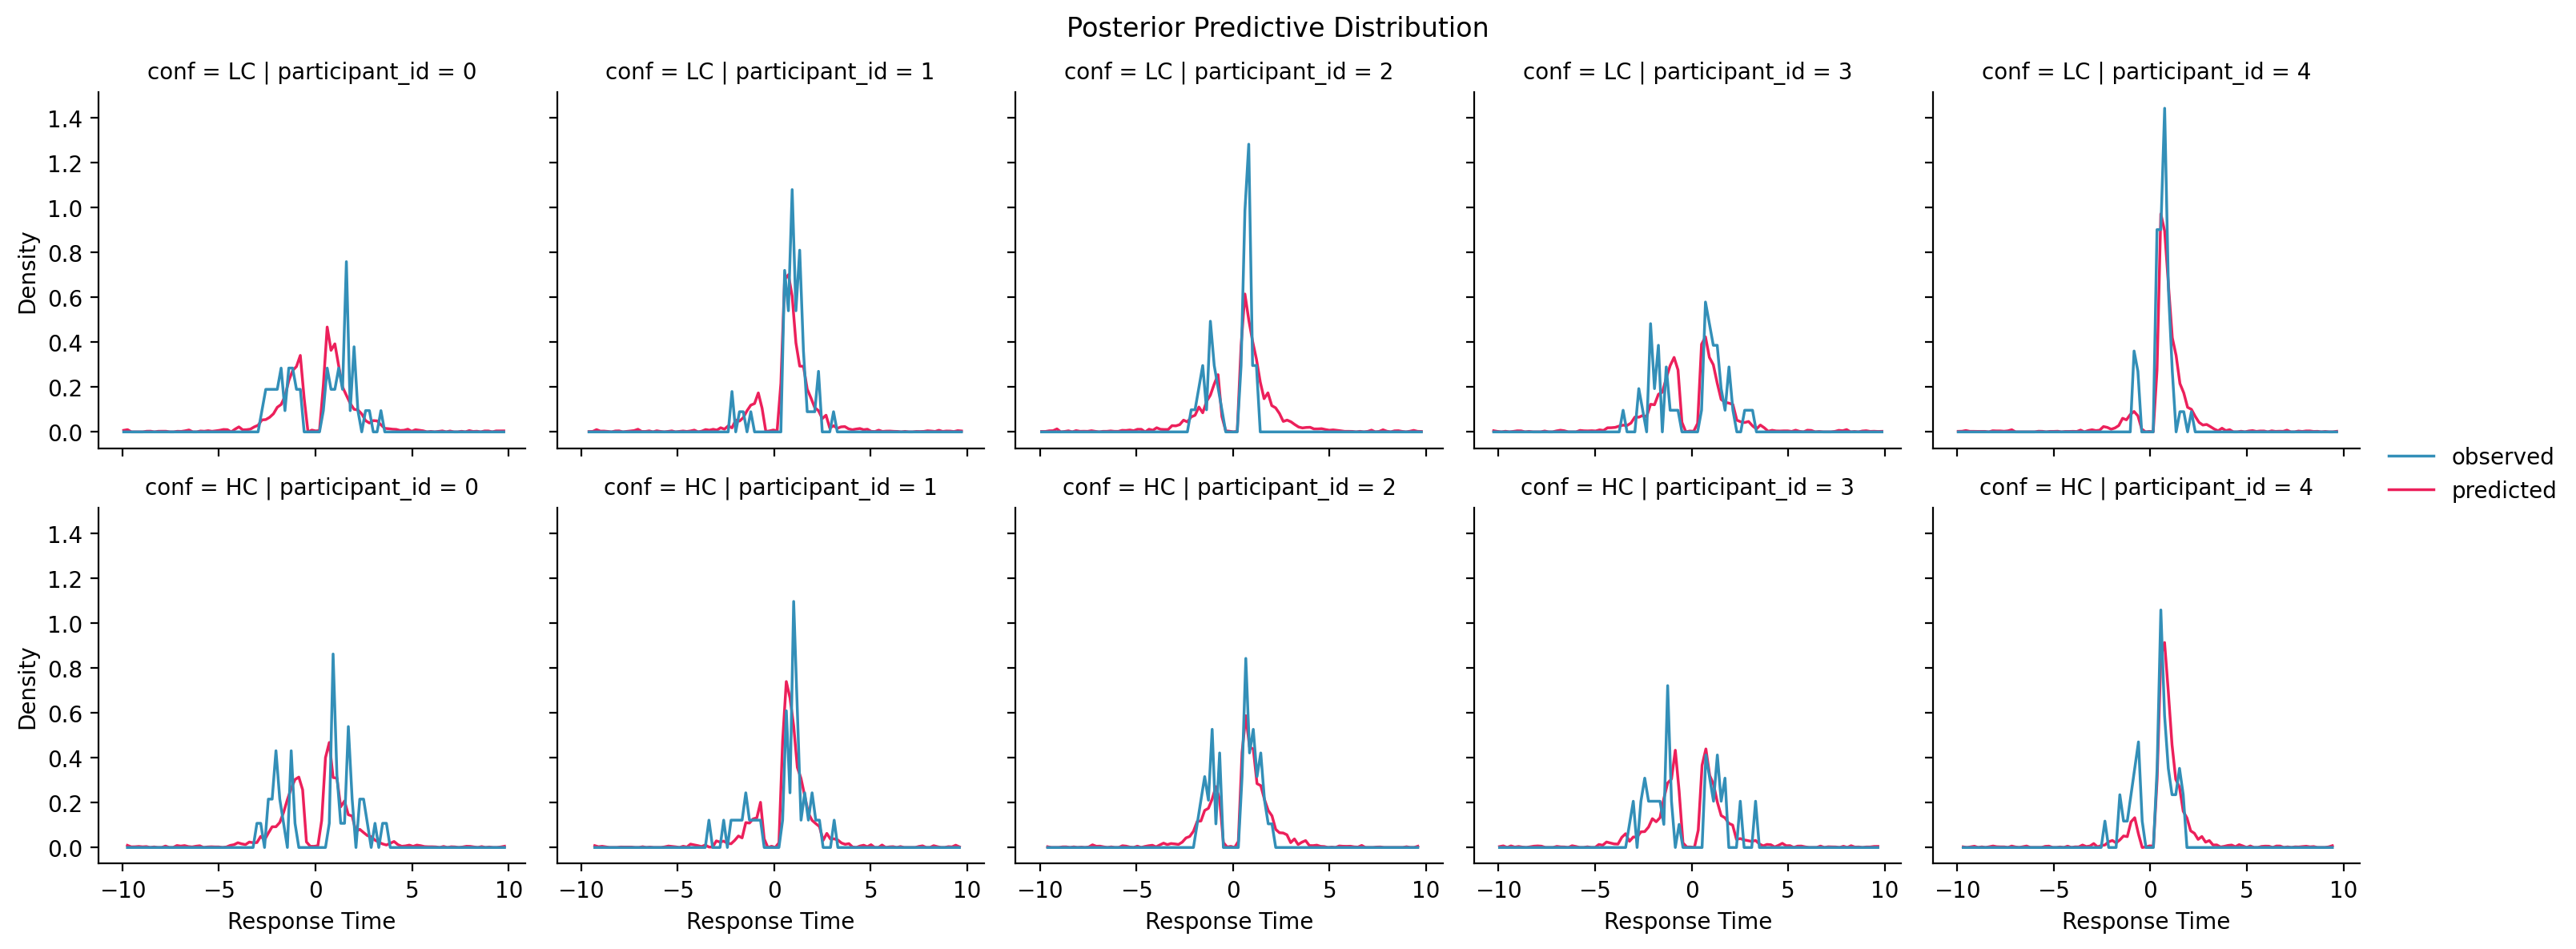

In [13]:
hssm.plotting.plot_posterior_predictive(
    cav_model,
    col="participant_id",
    row="conf",
)

When grids are used, this function returns a `sns.FacetGrid` object. You can also further customize your plot with this object as well. For example, you can set the titles each individual subplot according to a template or save the figure to disk (`g.savefig()`).

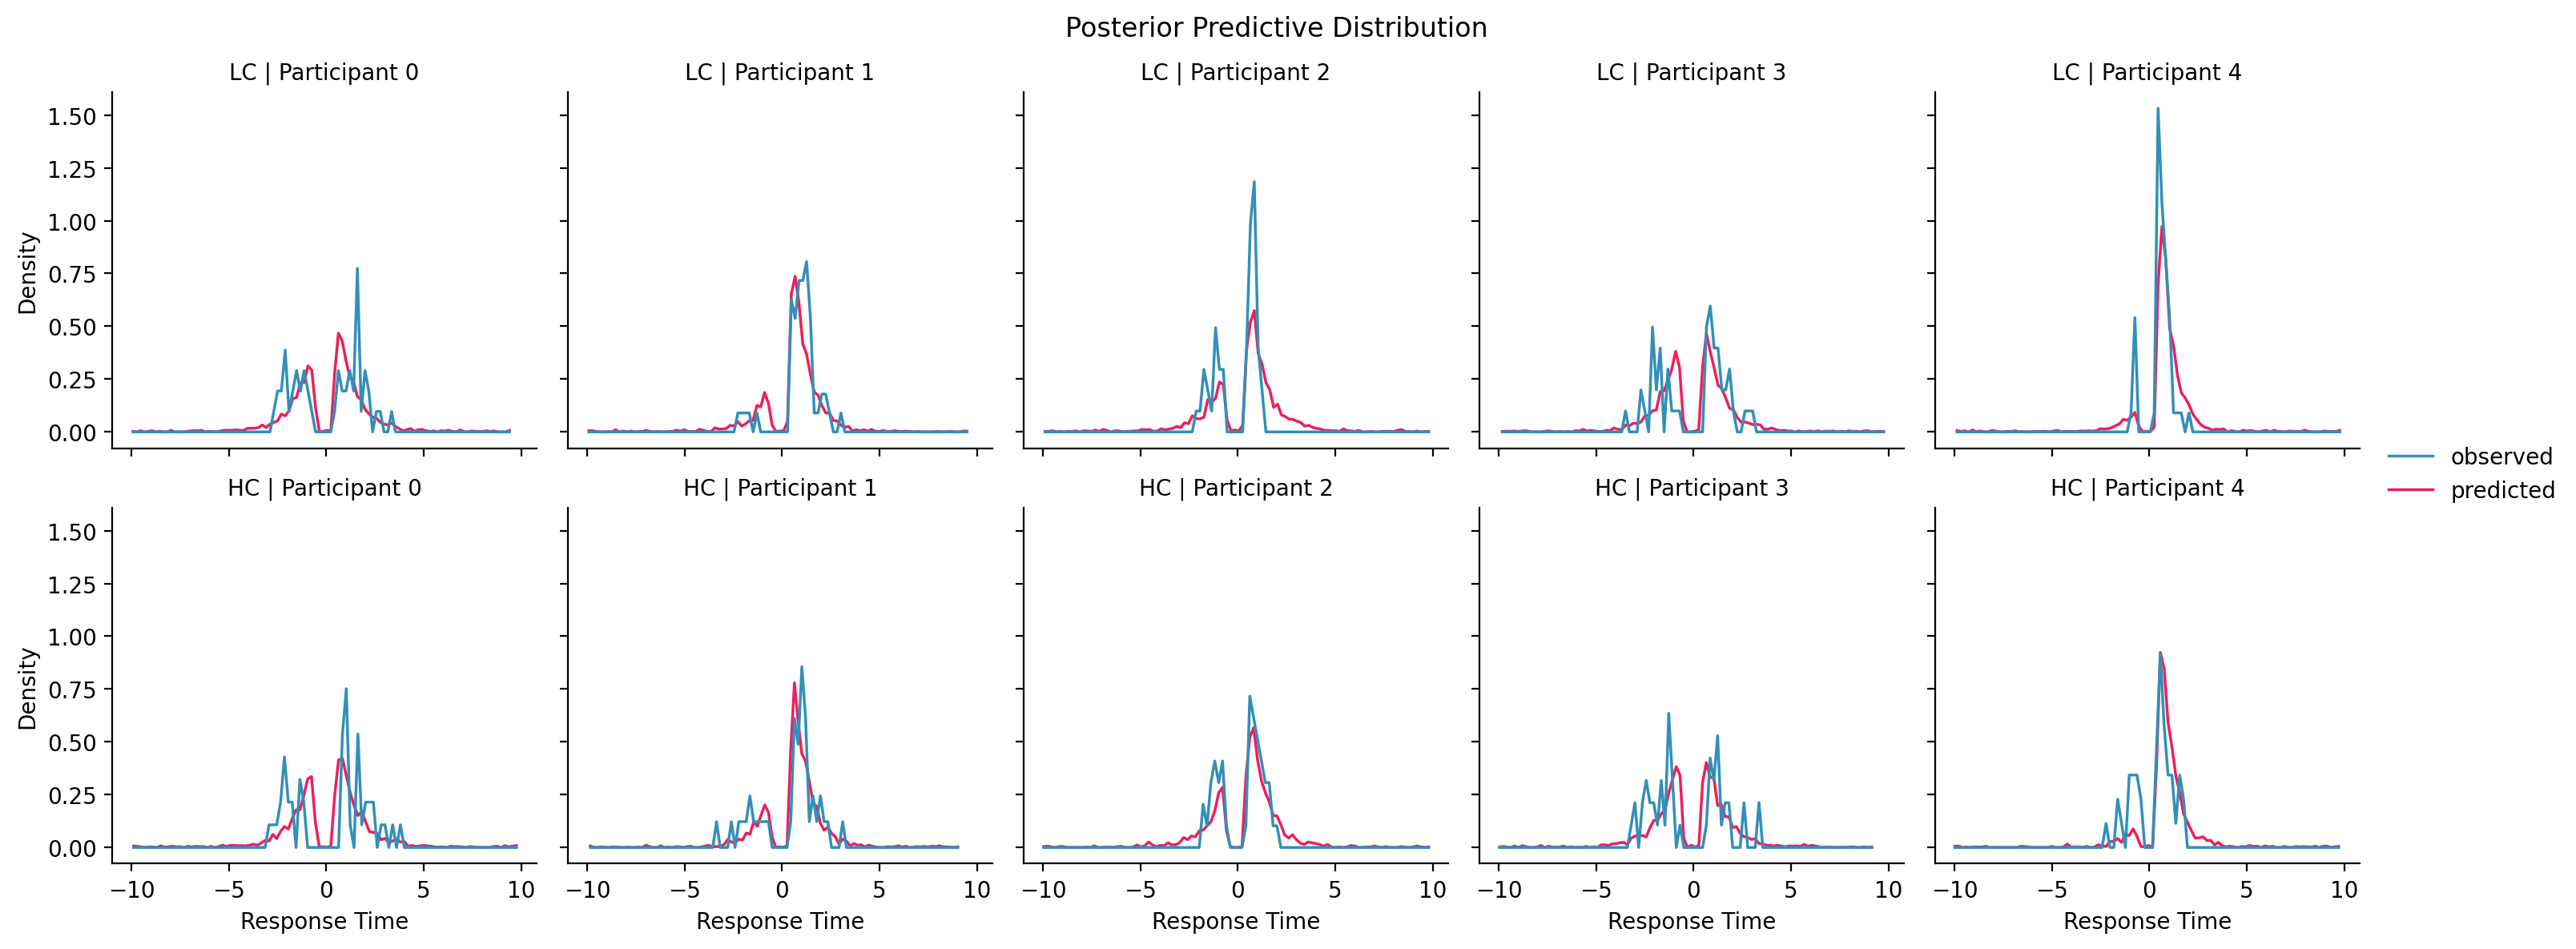

In [14]:
g = hssm.plotting.plot_posterior_predictive(
    cav_model,
    col="participant_id",
    row="conf",
)

g.set_titles(template="{row_name} | Participant {col_name}")

### 2. Quantile probability plots

Quantile probability plots [`hssm.plot_quantile_probability()`][hssm.plotting.plot_quantile_probability] are a type of plots useful for SSMs. For more information on quantile probability plots, please [see here](https://valeriobiscione.com/2015/02/20/quantile-probability-plot/).

`hssm.plotting.plot_quantile_probability()` works similarly to `hssm.plotting.plot_posterior_predictive()` in that when only producing one plot (no grid), it returns an axis object, and when it returns multiple plots, it produces a `FacetGrid` object

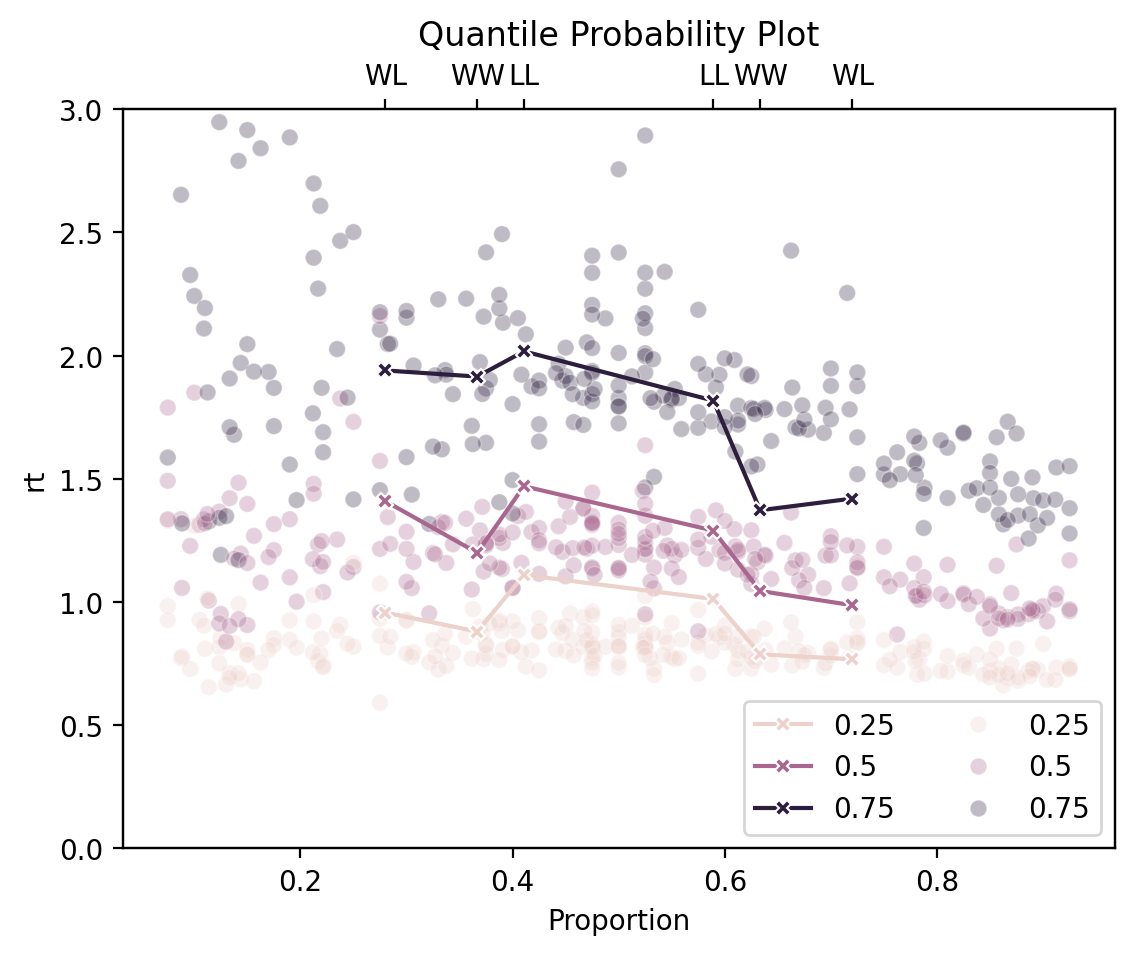

In [15]:
# Single plot, returns an axis object, which can be worked on further

ax = hssm.plotting.plot_quantile_probability(cav_model, cond="stim")
ax.set_ylim(0, 3);

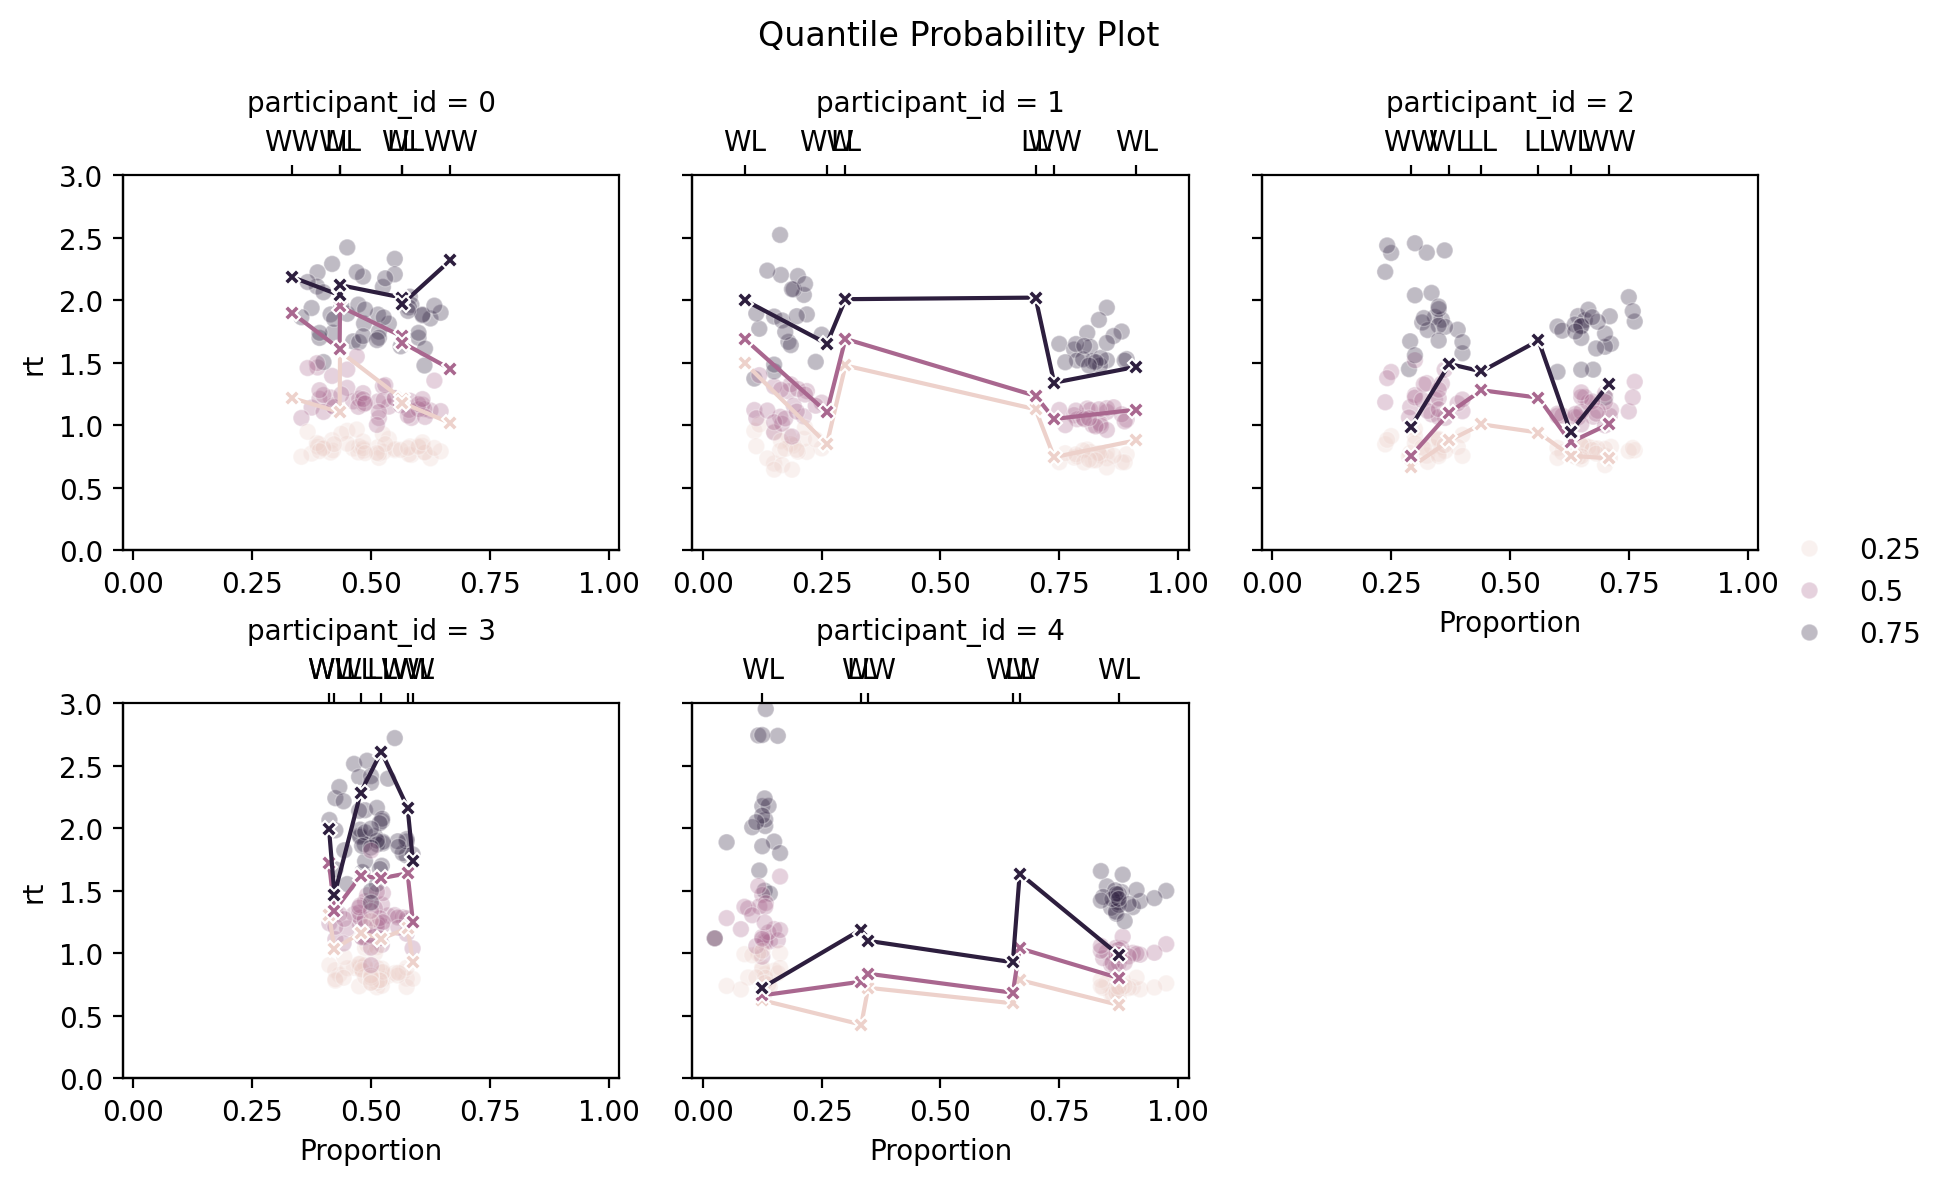

In [16]:
# Multiple plots, returns a FacetGrid

g = hssm.plotting.plot_quantile_probability(
    cav_model,
    cond="stim",
    col="participant_id",
    col_wrap=3,
    grid_kwargs=dict(
        ylim=(0, 3)
    ),  # additional kwargs to the grid can be passed through `grid_kwargs`
)